# **BRAIN SCAN PREDICTION**

This dataset contains MRI brain scan images of different types of tumors: glioma, meningioma, and pituitary, along with images with no tumor.

The goal is to train a model using these images to predict whether an MRI scan shows a tumor. If a tumor is present, the model will identify its type (glioma, meningioma, or pituitary).

## **IMPORTS**

In [1]:
# General imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


# Temsorflow imports 
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


## **DATA PREPARATION**

In [2]:

dataset_path = r"D:\MRI_Scan_Prediction\Training"

**Coverting images into Arrays and assigning labels**

In [3]:
# labels
labels_map = {
    "glioma": 0,
    "meningioma": 1,
    "notumor": 2,
    "pituitary": 3
}

# data and labels
data = []
labels = []

# Loop through each folder
for label_name, label_id in labels_map.items():
    folder_path = os.path.join(dataset_path, label_name)  
    for img_name in os.listdir(folder_path):  
        img_path = os.path.join(folder_path, img_name)  
        try:
            # resize image
            img = Image.open(img_path).convert('RGB')
            img = img.resize((224, 224))  
            img_array = np.array(img) 
            
            # Append data's
            data.append(img_array)
            labels.append(label_id)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# as arrays
data = np.array(data)
labels = np.array(labels)

print(f"Dataset size: {data.shape}, Labels size: {labels.shape}")


Dataset size: (5712, 224, 224, 3), Labels size: (5712,)


Assign the folder names and their corresponding labels, then loop through each folder to create arrays. While looping, assign the appropriate labels to each array

**Combing the data, label and making a dataframe**

In [4]:
# Flatten image 
data_flattened = data.reshape(data.shape[0], -1)  

# Combine labels
df = pd.DataFrame(data_flattened)  
df['label'] = labels 

print(df.head())
print(f"Dataset shape: {df.shape}")


   0  1  2  3  4  5  6  7  8  9  ...  150519  150520  150521  150522  150523  \
0  0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0       0   
1  0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0       0   
2  0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0       0   
3  0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0       0   
4  0  0  0  0  0  0  0  0  0  0  ...       0       0       0       0       0   

   150524  150525  150526  150527  label  
0       0       0       0       0      0  
1       0       0       0       0      0  
2       0       0       0       0      0  
3       0       0       0       0      0  
4       0       0       0       0      0  

[5 rows x 150529 columns]
Dataset shape: (5712, 150529)


**Testing ( by array to img )**

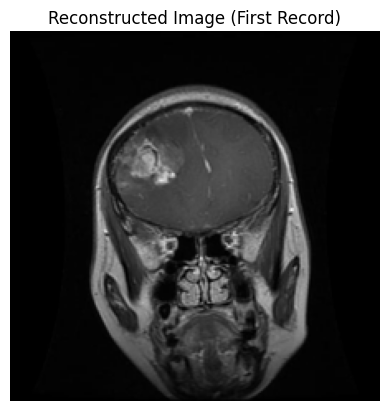

In [ ]:
first_image_flattened = df.iloc[0, :-1].values  
first_image_array = first_image_flattened.reshape(224, 224, 3)  

# back to image
reconstructed_image = Image.fromarray(first_image_array.astype('uint8'))

# plot
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image (First Record)")
plt.axis('off')
plt.show()

## **DATA SPLIT AND MODEL STRUCTURE**

**Converting images to arrays, storing in a DataFrame, and extracting X and y as numpy arrays before splitting preserves the order of images and labels**

In [6]:
# into array
data_array = df.iloc[:, :-1].values
labels_array = df['label'].values

# splits
X_train, X_test, y_train, y_test = train_test_split(data_array, labels_array, test_size = 0.2, random_state=42)

print(f"Training data shape:{X_train.shape}, Validation data shape : {X_test.shape}")

Training data shape:(4569, 150528), Validation data shape : (1143, 150528)


**Visualisation of Data split**

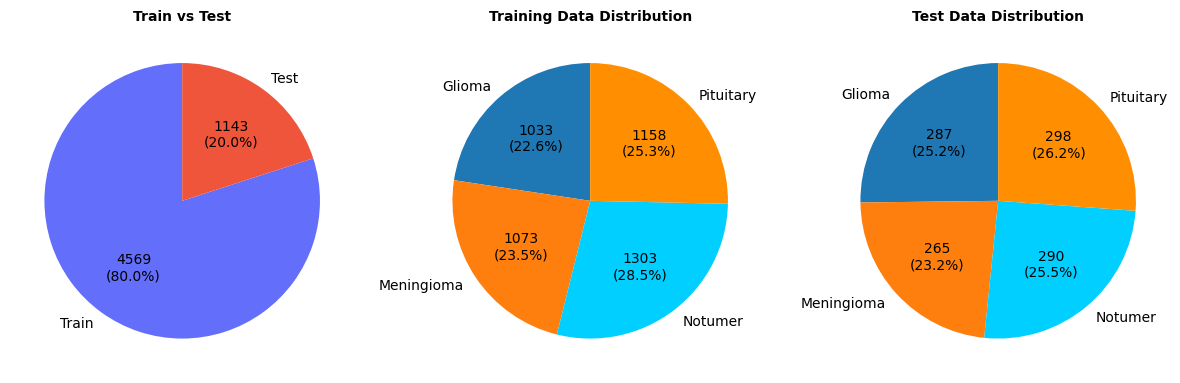

In [7]:
# data 
train_samples, test_samples = len(X_train), len(X_test)
class_names = ['Glioma', 'Meningioma', 'Notumer', 'Pituitary']
train_class_counts = pd.Series(y_train).value_counts()
test_class_counts = pd.Series(y_test).value_counts()

# Pie chart
split_data = {"Category": ["Train", "Test"], "Samples": [train_samples, test_samples]}
train_data = {"Category": class_names, "Samples": [train_class_counts.get(i, 0) for i in range(4)]}
test_data = {"Category": class_names, "Samples": [test_class_counts.get(i, 0) for i in range(4)]}
split_colors = ["#636EFA", "#EF553B"] 
train_colors = ["#1f77b4", "#ff7f0e", "#00CFFF", "#FF8F00"]  
test_colors = ["#1f77b4", "#ff7f0e", "#00CFFF", "#FF8F00"]  

def func(pct, allvals):
    absolute = int(pct / 100.*sum(allvals))  
    return f"{absolute}\n({pct:.1f}%)" 

# figure and axes
fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 

axes[0].pie(split_data["Samples"], labels=split_data["Category"], colors=split_colors,
            autopct=lambda pct: func(pct, split_data["Samples"]), startangle=90, textprops={'color': 'black'})
axes[0].set_title("Train vs Test", fontsize=10, fontweight='bold')

# Training Data
axes[1].pie(train_data["Samples"], labels=train_data["Category"], colors=train_colors,
            autopct=lambda pct: func(pct, train_data["Samples"]), startangle=90, textprops={'color': 'black'})
axes[1].set_title("Training Data Distribution", fontsize=10, fontweight='bold')

# Test Data 
axes[2].pie(test_data["Samples"], labels=test_data["Category"], colors=test_colors,
            autopct=lambda pct: func(pct, test_data["Samples"]), startangle=90, textprops={'color': 'black'})
axes[2].set_title("Test Data Distribution", fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


**Reshaping the data for CNN**

In [8]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 224, 224, 3)
X_test_reshaped = X_test.reshape(X_test.shape[0], 224, 224, 3)

print(f"Reshaped training data: {X_train_reshaped.shape}, Reshaped validation data: {X_test_reshaped.shape}")


Reshaped training data: (4569, 224, 224, 3), Reshaped validation data: (1143, 224, 224, 3)


**Preparing the model ( CNN Custom )**

**Used Pre-Trained CNN Model EfficientNetB0. And Tuned some layers based on some specifications. The model was compiled with the Adam optimizer and sparse categorical loss to minimize errors**

In [9]:
# Normalize pixel values
X_train_reshaped = X_train_reshaped.astype('float32') / 255.0
X_test_reshaped = X_test_reshaped.astype('float32') / 255.0

# pre-trained model (EfficientNetB0)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# tuning some layers
base_model.trainable = True
fine_tune_at = 100  
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.5)(x)  
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x) 

# output layer softmax
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])



**Visual Structue of Model**

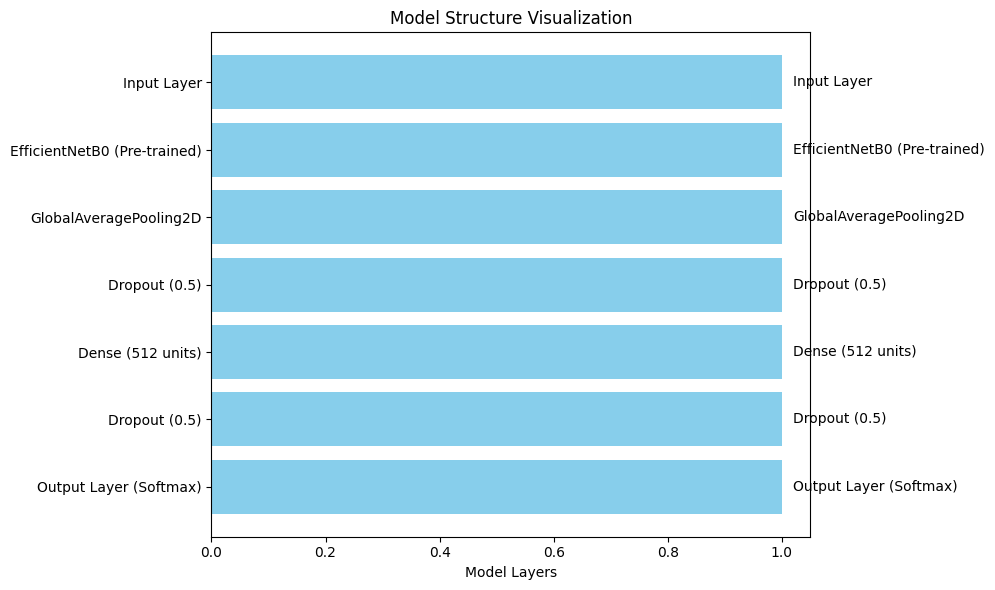

In [34]:
# layers of the model
layers = [
    'Input Layer', 'EfficientNetB0 (Pre-trained)', 'GlobalAveragePooling2D',
    'Dropout (0.5)', 'Dense (512 units)', 'Dropout (0.5)', 'Output Layer (Softmax)'
]

y_pos = np.arange(len(layers))

fig, ax = plt.subplots(figsize=(10, 6))

ax.barh(y_pos, np.ones_like(y_pos), align='center', color='skyblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(layers)
ax.invert_yaxis()

for i, layer in enumerate(layers):
    ax.text(1.02, i, layer, va='center', fontsize=10, color='black')

ax.set_xlabel('Model Layers')
ax.set_title('Model Structure Visualization')
plt.tight_layout()
plt.show()


In [ ]:
# early stopping and reducing learning rate 
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
# Train the model
history = model.fit(
    X_train_reshaped,
    y_train, 
    epochs=20, 
    validation_data=(X_test_reshaped, y_test), 
    callbacks=[early_stopping, reduce_lr],
    batch_size=32,  
    shuffle=True 
)

In [13]:
# # Save model
# model.save('mri_classification_pre-trained_model.h5')  
# print("Model saved successfully!")


In [ ]:
# Predict
predictions = model.predict(X_test_reshaped)
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

from sklearn.metrics import classification_report, confusion_matrix

# confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, predicted_classes, target_names=labels_map.keys())
print("\nClassification Report:")
print(class_report)


In [ ]:


# trained model
model = load_model('D:\MRI_Scan_Prediction\Training\mri_classification_pre-trained_model.h5')

# preprocess the image
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')  
    img = img.resize((224, 224)) 
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0) 
    img_array /= 255.0 
    return img_array

# predict
def predict_image(img_path):
    img_array = preprocess_image(img_path) 
    predictions = model.predict(img_array) 
    predicted_class = np.argmax(predictions, axis=1)  
    return predicted_class

# image path
img_path = r"D:\MRI_Scan_Prediction\Testing\glioma\Te-gl_0122.jpg"
predicted_class = predict_image(img_path)
print(f'Predicted class: {predicted_class[0]}')

In [ ]:
X_train_reshaped = X_train_reshaped / 255.0

In [ ]:


# number of classes
num_classes = 4

# Load saved model
model = load_model(r'D:\MRI_Scan_Prediction\Training\mri_classification_pre-trained_model.h5')

# Unfreeze layers for fine-tuning
for layer in model.layers[:-6]: 
    layer.trainable = False

# new layers
x = model.layers[-1].output 
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01), name='dense_new')(x)  
x = Dropout(0.6, name='dropout_new')(x)  
output = Dense(num_classes, activation='softmax', name='output')(x)  

# new model
new_model = tf.keras.Model(inputs=model.input, outputs=output)

# higher learning rate
new_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# EarlyStopping and ModelCheckpoint
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('fine_tuned_best_model.keras', monitor='val_accuracy', save_best_only=True)

# training and validation 
X_train, X_val, y_train, y_val = train_test_split(
    X_train_reshaped, 
    y_train,          
    test_size=0.2,   
    random_state=42   
)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=num_classes)  
y_val = to_categorical(y_val, num_classes=num_classes)

# Fine-tune model 
history = new_model.fit(
    datagen.flow(X_train, y_train, batch_size=64), 
    epochs=15, 
    validation_data=(X_val, y_val),  
    callbacks=[early_stop, checkpoint]  
)

# saving fine-tuned model
new_model.save('fine_tuned_model_pre_trained.keras')


print("Training History:")
print(history.history)


In [ ]:
# Plot accuracy and loss curves during training


plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot the loss curves during training
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:

# Load model
model = load_model('fine_tuned_model.keras') 

# image path
img_path = r"D:\MRI_Scan_Prediction\Testing\meningioma\Te-me_0158.jpg" 
img = image.load_img(img_path, target_size=(224, 224))  

# image to array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) 

# Normalize 
img_array = img_array / 255.0 

# Predict 
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=-1) 
predicted_class_prob = np.max(predictions) 

print(f'Predicted Class Index: {predicted_class_index}')
print(f'Predicted Class Probability: {predicted_class_prob}')

# class label mapping
class_labels = ['class_0', 'class_1', 'class_2', 'class_3']  
predicted_class_name = class_labels[predicted_class_index[0]]  

print(f'Predicted Class Name: {predicted_class_name}')
